## Reload the `EC_estimator.py` code to consider any changes

In [106]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import EC_estimator as annec

import EC_estimator as annec

In [79]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

## Load the dataset, preprocessing, and apply ANN model

In [82]:
# Load data
df = annec.load_data('Inputs/inputs.csv')
df_var = annec.df_by_variable(df)

# Split data
train_rows = df.shape[0] - 6039
df_train, df_test = annec.split_data(df_var, train_rows, 6039)

# Build model inputs
inputs = annec.build_model_inputs(df)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)

# Define training and testing data
X_train = [ df_train.loc[:, pd.IndexSlice[feature,:]] for feature in annec.feature_names()]
y_train = df_train[('EC','0d')].to_frame()  # situation where one column is produced and coerced to a series
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"emm_ec"})
y_train.columns = ["emm_ec"]



X_test = [ df_test.loc[:, pd.IndexSlice[feature,:]] for feature in annec.feature_names()]


y_test = df_test[('EC','0d')].to_frame()  # Only works for univariate dataset where it is a series
y_test.columns = ["emm_ec"] 


# Train model
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test)

## Illustration of by-variable input (df_var)

In [61]:
df = annec.load_data('Inputs/inputs.csv')

# This will break up the incoming DataFrame into a MultiIndex column
# with the site/variable (e.g. Sac) as the 0-level index and
# lag (e.g. '3d') as the fast index.
df_var = annec.df_by_variable(df)

# This is an illustration of how to extract a single location/variable
# so that it (with its lags) can be used as a single input in the ANN. 
# In the traditional CalSIM model would be 18 values 
# The droplevel gets rid of the vestiges of the multiindex
sac = df_var.loc[:, pd.IndexSlice['sac',:]].droplevel(level="var",axis=1)
print(sac.head(4))





lag           0d           1d           2d           3d           4d  \
0    22290.01548  22333.70068  22358.59029  22373.94862  22383.92889   
1    22203.28407  22290.01548  22333.70068  22358.59029  22373.94862   
2    21992.03107  22203.28407  22290.01548  22333.70068  22358.59029   
3    18938.58199  21992.03107  22203.28407  22290.01548  22333.70068   

lag           5d           6d           7d         1ave         2ave  \
0    22390.61113  22395.12267  22398.10862  22391.45013  20455.31666   
1    22383.92889  22390.61113  22395.12267  22394.40549  21187.05572   
2    22373.94862  22383.92889  22390.61113  22396.15244  21864.78865   
3    22358.59029  22373.94862  22383.92889  22396.79180  22157.44139   

lag         3ave         4ave         5ave         6ave         7ave  \
0    13808.89333  13727.31347  15871.35388  18889.58980  19086.62041   
1    13863.05279  13723.46477  15415.59194  18875.79859  19027.33307   
2    13971.76887  13721.41293  14965.45140  18855.52854  18992

## Evaluation of the model

In [83]:
# Calculate metrics for ANN
print(model.summary())
metrics = []
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))



Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sac_input (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 exports_input (InputLayer)     [(None, 18)]         0           []                               
                                                                                                  
 dcc_input (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 net_dcd_input (InputLayer)     [(None, 18)]         0           []                               
                                                                                           

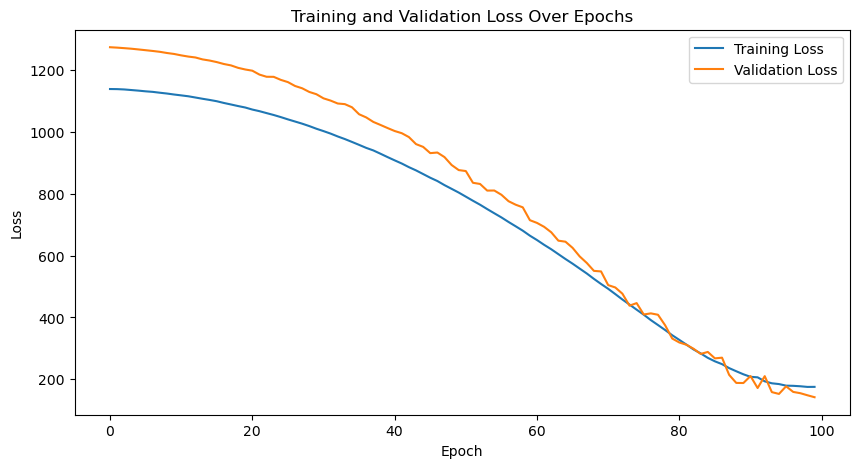

In [ ]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

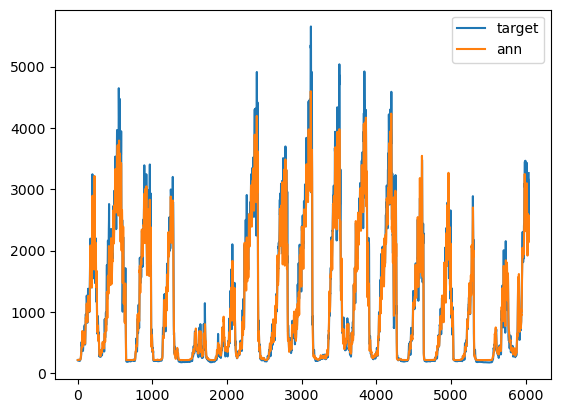

In [84]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [85]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [86]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


189/189 [==============================] - 1s 3ms/step
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.98 |       133.19 |                    5.54 |      0.97 |      184.18 |                   1.69 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process. I have just left it in place, but without 

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
# Load the saved model
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})


new_data = pd.read_csv('./Inputs/inputs.csv')

# Eli note: Don't think it is used any more
num_features = [
    'sac', 'exports', 'dcc', 'net_dcd', 'sjr', 'tide', 'smscg', 'sac_1d', 'exports_1d', 'dcc_1d', 
    'net_dcd_1d', 'sjr_1d', 'tide_1d', 'smscg_1d', 'sac_2d', 'exports_2d', 'dcc_2d', 'net_dcd_2d', 
    'sjr_2d', 'tide_2d', 'smscg_2d', 'sac_3d', 'exports_3d', 'dcc_3d', 'net_dcd_3d', 'sjr_3d', 'tide_3d', 
    'smscg_3d', 'sac_4d', 'exports_4d', 'dcc_4d', 'net_dcd_4d', 'sjr_4d', 'tide_4d', 'smscg_4d', 'sac_5d', 
    'exports_5d', 'dcc_5d', 'net_dcd_5d', 'sjr_5d', 'tide_5d', 'smscg_5d', 'sac_6d', 'exports_6d', 'dcc_6d', 
    'net_dcd_6d', 'sjr_6d', 'tide_6d', 'smscg_6d', 'sac_7d', 'exports_7d', 'dcc_7d', 'net_dcd_7d', 'sjr_7d', 
    'tide_7d', 'smscg_7d', 'sac_1ave', 'exports_1ave', 'dcc_1ave', 'net_dcd_1ave', 'sjr_1ave', 'tide_1ave', 
    'smscg_1ave', 'sac_2ave', 'exports_2ave', 'dcc_2ave', 'net_dcd_2ave', 'sjr_2ave', 'tide_2ave', 'smscg_2ave', 
    'sac_3ave', 'exports_3ave', 'dcc_3ave', 'net_dcd_3ave', 'sjr_3ave', 'tide_3ave', 'smscg_3ave', 'sac_4ave', 
    'exports_4ave', 'dcc_4ave', 'net_dcd_4ave', 'sjr_4ave', 'tide_4ave', 'smscg_4ave', 'sac_5ave', 'exports_5ave', 
    'dcc_5ave', 'net_dcd_5ave', 'sjr_5ave', 'tide_5ave', 'smscg_5ave', 'sac_6ave', 'exports_6ave', 'dcc_6ave', 
    'net_dcd_6ave', 'sjr_6ave', 'tide_6ave', 'smscg_6ave', 'sac_7ave', 'exports_7ave', 'dcc_7ave', 'net_dcd_7ave', 
    'sjr_7ave', 'tide_7ave', 'smscg_7ave', 'sac_8ave', 'exports_8ave', 'dcc_8ave', 'net_dcd_8ave', 'sjr_8ave', 
    'tide_8ave', 'smscg_8ave', 'sac_9ave', 'exports_9ave', 'dcc_9ave', 'net_dcd_9ave', 'sjr_9ave', 'tide_9ave', 
    'smscg_9ave', 'sac_10ave', 'exports_10ave', 'dcc_10ave', 'net_dcd_10ave', 'sjr_10ave', 'tide_10ave', 'smscg_10ave'
]



X_new = [new_data[feature] for feature in num_features]
predictions = loaded_model.predict(X_new)

from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv('C:/Users/hzamanis/Documents/ann_CalSim_EC_estimator/ann_CalSim_EC_estimator/Inputs/inputs.csv')
df['ANN_EC']= predictions
total_rows = df.shape[0]
test_rows = 6039
train_rows = total_rows - test_rows
df_train = df.tail(train_rows)
df_test = df.head(test_rows)

r2 = r2_score(df['EC'], df['ANN_EC'])
r2_Test = r2_score(df_test['EC'], df_test['ANN_EC'])
r2_Train = r2_score(df_train['EC'], df_train['ANN_EC'])
print('R2_Train:',round(r2_Train,2),', R2_Test:',round(r2_Test,2),', R2_All:',round(r2,2))

R2_Train: 0.98 , R2_Test: 0.97 , R2_All: 0.98


In [99]:
###### Single sample Test ####
snv=[22290.01548,	1734.942768,	0,	-9.952951431,	6335.896343,	5.556299686,	1,	22333.70068,	1734.942768,	0,	-9.952951431,	6355.438848,	5.346099854,	1,	22358.59029,	
    1734.942768,	0,	-9.952951431,	6366.577922,	4.948599815,	1,	22373.94862,	1734.942768,	0,	-9.952951431,	6373.457067,	4.631799698,	1,	22383.92889,	1734.942768,	
    0,	-9.952951431,	6377.9341,	4.35890007,	1,	22390.61113,	1734.942768,	0,	-9.952951431,	6380.939775,	4.41920042,	1,	22395.12267,	1734.942768,	0,	-9.952951431,	6382.978897,
    4.609300137,	1,	22398.10862,	1734.942768,	0,	-9.952951431,	6384.340773,	4.885900021,	1,	22391.45013,	1734.942768,	0,	-9.952951431,	6381.83493,	4.891309001,	1,	
    20455.31666,	2414.233676,	0,	112.3443529,	5732.819247,	5.957036409,	1,	13808.89333,	5471.04276,	0,	662.6822227,	3675.128419,	4.531345497,	1,	13727.31347,	5471.04276,	
    0,	662.6822227,	3633.416262,	5.270854516,	1,	15871.35388,	6109.499427,	0,	435.5286874,	3856.175652,	5.932472706,	1,	18889.5898,	7226.798596,	0,	38.01000071,	4164.807632,
    4.630736351,	1,	19086.62041,	7226.798596,	0,	38.01000071,	4154.380322,	5.861154643,	1,	27995.04227,	7136.866161,	0,	221.055452,	3569.548577,	5.481718107,	1,	29834.38514,
    7116.881175,	0,	261.732219,	3451.610338,	6.283490961,	1,	30086.23375,	7116.881175,	0,	261.732219,	3441.636806,	6.154863574,	1
]  # Numerical parameters ((the time serie values of current day + 7 days ago + 10 blocks of previous 11 days)= 118 days of data  (18 input values*7 predictors = 126 values as input parameters)


single_sample_list = []
for value, feature_name in zip(snv , num_features ):
    single_sample_df = pd.DataFrame([value], columns=[feature_name])
    single_sample_list.append(single_sample_df)

# Predict for the single sample
p = loaded_model.predict(single_sample_list)

print('Single Sample Prediction:', p)

NameError: name 'num_features' is not defined